In [87]:
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [97]:
from tqdm.notebook import tqdm_notebook

tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [57]:
pickl_h_train = pd.read_pickle('dataset/outfox/human/train_humans.pkl')
pickl_h_test = pd.read_pickle('dataset/outfox/human/test_humans.pkl')
pickl_h_valid = pd.read_pickle('dataset/outfox/human/valid_humans.pkl')
df_human_test = pd.DataFrame(pickl_h_test)
df_human_train = pd.DataFrame(pickl_h_train)
df_human_valid = pd.DataFrame(pickl_h_valid)
df_human = pd.concat([df_human_train, df_human_test, df_human_valid], ignore_index=True)
df_human.rename(columns={0: 'text'}, inplace=True)
df_human['generated'] = 0
df_human

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
15395,"Should students have classes from home, base i...",0
15396,Driveress cars are in our future because of al...,0
15397,Are dreiverless cars a good idea for the futur...,0
15398,Sometimes school can be to much for a person. ...,0


In [58]:
pickl_gpt_train = pd.read_pickle('dataset/outfox/gpt/train_lms.pkl')
pickl_gpt_test = pd.read_pickle('dataset/outfox/gpt/test_lms.pkl')
pickl_gpt_valid = pd.read_pickle('dataset/outfox/gpt/valid_lms.pkl')
df_gpt_train = pd.DataFrame(pickl_gpt_train)
df_gpt_test = pd.DataFrame(pickl_gpt_test)
df_gpt_valid = pd.DataFrame(pickl_gpt_valid)
df_gpt = pd.concat([df_gpt_train, df_gpt_test, df_gpt_valid], ignore_index=True)
df_gpt.rename(columns={0: 'text'}, inplace=True)
df_gpt['generated'] = 1
df_gpt

,text,generated
0,The world is rapidly advancing towards advance...,1
1,The Electoral College is a unique system that ...,1
2,The COVID-19 pandemic has negatively affected ...,1
3,"Driving is inherently risky, and the chances o...",1
4,The issue of car-free cities has gained more a...,1
...,...,...
15395,The idea of students taking classes from home ...,1
15396,"Over the past few years, the technology for dr...",1
15397,With technological advancements paving the way...,1
15398,The educational landscape has undergone a tran...,1


In [60]:
df = pd.concat([df_human, df_gpt], ignore_index=True)

In [62]:
df.head()

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0


In [63]:
df['generated'].value_counts()

0    15400
1    15400
Name: generated, dtype: int64

In [69]:
# total 85 duplicates only in human-written texts
df[df.duplicated(keep=False) == True]['generated'].value_counts()

0    170
Name: generated, dtype: int64

In [72]:
df = df.drop_duplicates()
df

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
30795,The idea of students taking classes from home ...,1
30796,"Over the past few years, the technology for dr...",1
30797,With technological advancements paving the way...,1
30798,The educational landscape has undergone a tran...,1


In [115]:
def tokenize_and_clean_text(text):
    tokens = tokenize.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punct_chars = string.punctuation + "'s" + '""' + '...' + "''" + '``'
    filtered_tokens = [word.lower() for word in tokens if word not in stop_words and word not in punct_chars]
    return filtered_tokens

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def get_mean_sent_char_length(sent_tokens):
    return np.mean([len(sent) for sent in sent_tokens])

def get_mean_sent_word_length(sent_tokens):
    return np.mean([len(sent.split()) for sent in sent_tokens])

def new_lines_quantity(text):
    pattern = r'(\n)'
    matches = re.findall(pattern, text)
    return len(matches)

In [75]:
df['BoW_raw'] = df['text'].apply(tokenize_and_clean_text)

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_4196/439285983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_raw'] = df['text'].apply(tokenize_and_clean_text)


In [84]:
df.loc[:, 'text_length'] = df['BoW_raw'].apply(lambda x: len(x))

In [88]:
df.loc[:, 'average_word_length'] = tqdm(df['BoW_raw'].apply(lambda x: np.mean([len(word) for word in x if word.isalpha()])))

100%|████████████████████████████████| 30715/30715 [00:00<00:00, 2336804.78it/s]
/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [92]:
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].mean())

12
1164
257.90926257528895


In [100]:
df.loc[:, 'text_sent_length'] = df.loc[:, 'text'].progress_apply(tokenize.sent_tokenize).apply(len)

  0%|          | 0/30715 [00:00<?, ?it/s]

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [104]:
df.loc[:,'mean_sentence_length_chars'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_char_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [105]:
df['mean_sentence_length_words'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_4196/3673438495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_sentence_length_words'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)


In [107]:
df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_4196/3186995282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)


In [110]:
df.loc[:, 'tokens_num'] = df.loc[:, 'BoW_lemmatized'].apply(len).astype('int16')

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [113]:
df.loc[:, 'unique_words'] = df.loc[:, 'BoW_raw'].apply(lambda x: len(set(x)))
df.loc[:, 'unique_ratio'] = df.loc[:, 'unique_words'] / df.loc[:, 'BoW_raw'].apply(len)

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [117]:
df.loc[:, 'new_lines_quant'] = df.loc[:, 'text'].apply(new_lines_quantity)

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


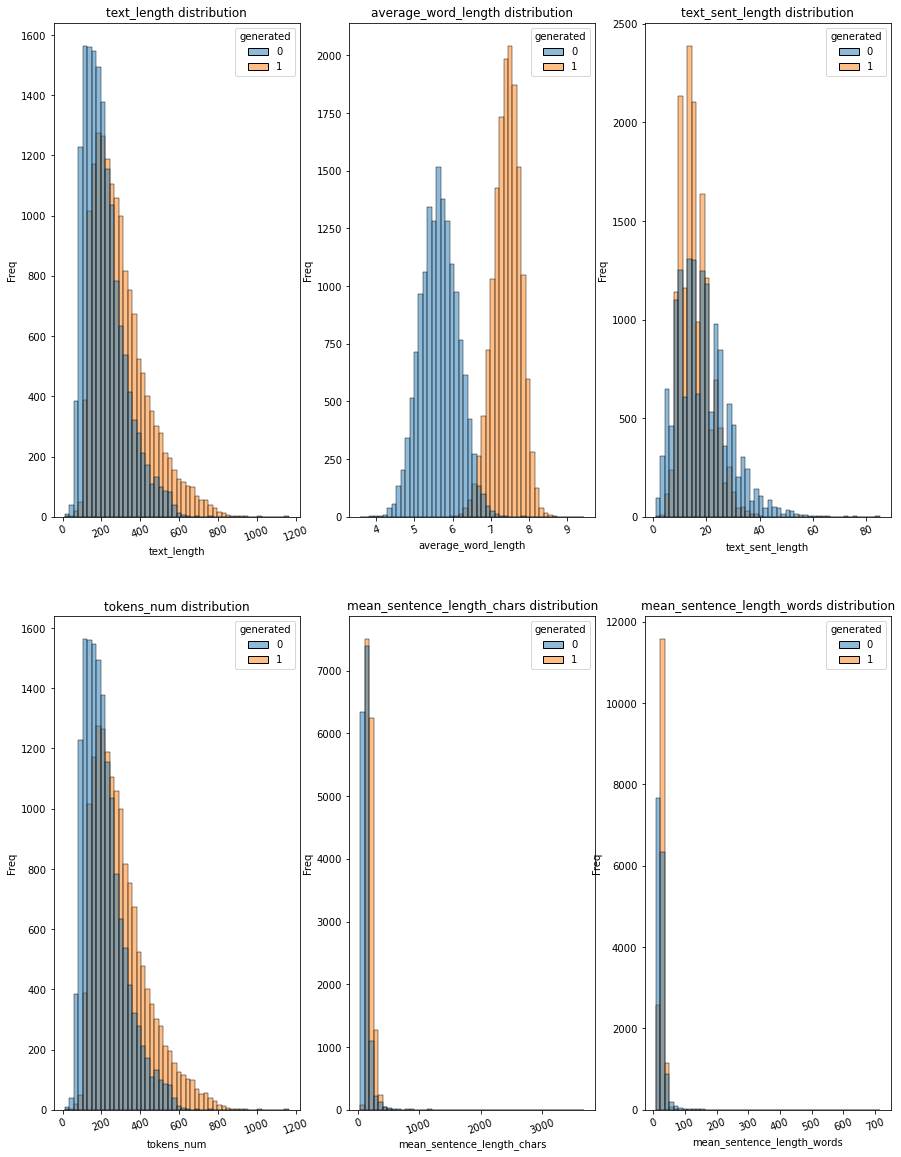

In [119]:
num_cols = df[['text_length', 'average_word_length', 'text_sent_length', 'tokens_num', 'mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [121]:
cnt = Counter()
df['BoW_raw'].progress_apply(lambda x: ''.join(x)).progress_apply(cnt.update)
cnt

  0%|          | 0/30715 [00:00<?, ?it/s]

  0%|          | 0/30715 [00:00<?, ?it/s]

Counter({'d': 2005819,
         'r': 3335483,
         'i': 4557592,
         'v': 856709,
         'e': 6848494,
         'l': 2808312,
         's': 4182840,
         'c': 2459411,
         'a': 3841550,
         'w': 542708,
         'y': 863050,
         'n': 4115604,
         't': 4180087,
         'h': 1185487,
         'o': 3506286,
         'u': 1707400,
         'g': 1533259,
         'm': 1405038,
         'p': 1542340,
         'j': 74086,
         'k': 414552,
         'f': 767784,
         'b': 584370,
         'x': 159080,
         'z': 56999,
         '2': 12888,
         '-': 133264,
         '.': 12805,
         '3': 6648,
         '1': 14438,
         "'": 44005,
         '9': 7180,
         '_': 4078,
         '6': 4699,
         '7': 5154,
         'q': 68818,
         '5': 6183,
         '0': 21364,
         ',': 1600,
         '/': 7827,
         '4': 4476,
         '8': 4552,
         '´': 261,
         '~': 25,
         '\x92': 89,
         'ã': 126,
         '\

In [122]:
cnt_lemm = Counter()
df['BoW_lemmatized'].progress_apply(cnt_lemm.update)
lemm_unigramms = cnt_lemm.most_common()
lemm_unigramms

  0%|          | 0/30715 [00:00<?, ?it/s]

[('student', 111922),
 ('people', 53978),
 ('would', 52722),
 ('school', 52261),
 ('car', 51829),
 ('the', 48234),
 ('i', 46630),
 ('one', 42200),
 ('time', 35620),
 ('could', 34687),
 ("n't", 31988),
 ('help', 30739),
 ('in', 30058),
 ('learning', 29400),
 ('like', 28991),
 ('also', 28588),
 ('make', 28453),
 ('get', 27589),
 ('class', 25904),
 ('electoral', 25803),
 ('many', 25247),
 ('state', 24792),
 ('vote', 24661),
 ('phone', 24592),
 ('may', 24277),
 ('project', 23691),
 ('college', 23571),
 ('activity', 23409),
 ('way', 22563),
 ('life', 22562),
 ('system', 22290),
 ('work', 21728),
 ('need', 21387),
 ('it', 21199),
 ('teacher', 20916),
 ('benefit', 20218),
 ('this', 19800),
 ('even', 19686),
 ('driving', 19626),
 ('online', 19504),
 ('better', 19238),
 ('technology', 18713),
 ('think', 18592),
 ('venus', 18006),
 ('thing', 17409),
 ('use', 17408),
 ('opinion', 17241),
 ('take', 17084),
 ('community', 16647),
 ('advice', 16425),
 ('good', 16157),
 ('new', 15652),
 ('different',

In [123]:
cnt_lemm.most_common(20)

[('student', 111922),
 ('people', 53978),
 ('would', 52722),
 ('school', 52261),
 ('car', 51829),
 ('the', 48234),
 ('i', 46630),
 ('one', 42200),
 ('time', 35620),
 ('could', 34687),
 ("n't", 31988),
 ('help', 30739),
 ('in', 30058),
 ('learning', 29400),
 ('like', 28991),
 ('also', 28588),
 ('make', 28453),
 ('get', 27589),
 ('class', 25904),
 ('electoral', 25803)]

In [126]:
unigrams = {key: value for key, value in lemm_unigramms}
unigrams

{'student': 111922,
 'people': 53978,
 'would': 52722,
 'school': 52261,
 'car': 51829,
 'the': 48234,
 'i': 46630,
 'one': 42200,
 'time': 35620,
 'could': 34687,
 "n't": 31988,
 'help': 30739,
 'in': 30058,
 'learning': 29400,
 'like': 28991,
 'also': 28588,
 'make': 28453,
 'get': 27589,
 'class': 25904,
 'electoral': 25803,
 'many': 25247,
 'state': 24792,
 'vote': 24661,
 'phone': 24592,
 'may': 24277,
 'project': 23691,
 'college': 23571,
 'activity': 23409,
 'way': 22563,
 'life': 22562,
 'system': 22290,
 'work': 21728,
 'need': 21387,
 'it': 21199,
 'teacher': 20916,
 'benefit': 20218,
 'this': 19800,
 'even': 19686,
 'driving': 19626,
 'online': 19504,
 'better': 19238,
 'technology': 18713,
 'think': 18592,
 'venus': 18006,
 'thing': 17409,
 'use': 17408,
 'opinion': 17241,
 'take': 17084,
 'community': 16647,
 'advice': 16425,
 'good': 16157,
 'new': 15652,
 'different': 15601,
 'a': 15284,
 'decision': 15032,
 'want': 14918,
 'go': 14877,
 'human': 14748,
 'know': 14466,
 

In [127]:
def get_words_as_text(tokens):
    return ' '.join(tokens)

In [128]:
words = df['BoW_raw'].apply(get_words_as_text)
words_as_texts = ' '.join(words)
all_words = words_as_texts.split()

In [130]:
bigrams = nltk.ngrams(all_words, 2)
cnt_bigrams = Counter(bigrams)
bigr = cnt_bigrams.most_common()

In [131]:
bigrams_freq = {' '.join(key): value for key, value in bigr}
bigrams_freq

{'electoral college': 19124,
 'driverless cars': 9390,
 'in conclusion': 7581,
 'community service': 7360,
 'cell phones': 6740,
 'i think': 6441,
 'extracurricular activities': 6056,
 'distance learning': 5621,
 'popular vote': 5176,
 'united states': 4723,
 'summer projects': 4706,
 'online classes': 4576,
 'the electoral': 4327,
 'for example': 4322,
 'cell phone': 3805,
 'one person': 3464,
 'car usage': 3445,
 'i believe': 3363,
 'face mars': 3301,
 'students would': 3198,
 'many people': 3129,
 'multiple opinions': 3124,
 "would n't": 2858,
 'college system': 2836,
 "ca n't": 2828,
 'classes home': 2798,
 'multiple people': 2669,
 'seeking advice': 2334,
 'i would': 2295,
 'many students': 2190,
 'high school': 2151,
 "wo n't": 2144,
 'electoral votes': 2127,
 'driverless car': 2118,
 'seagoing cowboys': 2058,
 'extracurricular activity': 1997,
 'texting driving': 1924,
 'even though': 1893,
 'seeking multiple': 1867,
 'limiting car': 1860,
 'facial action': 1824,
 'online learni

In [132]:
trigrams = nltk.ngrams(all_words, 3)
cnt_trigrams = Counter(trigrams)
trigr = cnt_trigrams.most_common()

In [133]:
trigrams_freq = {' '.join(key): value for key, value in trigr}
trigrams_freq

{'the electoral college': 4054,
 'electoral college system': 2791,
 'facial action coding': 1742,
 'limiting car usage': 1588,
 'action coding system': 1574,
 'seeking multiple opinions': 1540,
 'use cell phones': 1489,
 'attend classes home': 1202,
 'seagoing cowboys program': 1004,
 'president united states': 972,
 'seeking advice multiple': 940,
 'cell phones school': 858,
 'in essay i': 799,
 'cell phone use': 773,
 'the face mars': 767,
 'make better choice': 744,
 'ask one person': 708,
 'advice multiple sources': 691,
 'students would benefit': 688,
 'cell phones driving': 654,
 'advice multiple people': 652,
 'electoral college unfair': 642,
 'online video conferencing': 641,
 'greenhouse gas emissions': 627,
 'popular vote system': 626,
 'able attend classes': 618,
 'one extracurricular activity': 565,
 'in recent years': 554,
 'election popular vote': 548,
 'challenge exploring venus': 535,
 'asking multiple people': 532,
 'using cell phones': 531,
 'one person advice': 525,


In [134]:
def get_pos(tokens):
    return [tag for word, tag in nltk.pos_tag(tokens, lang='eng')]

In [136]:
cnt_pos = Counter()
df['BoW_raw'].progress_apply(get_pos).apply(cnt_pos.update)
pos_count = cnt_pos.most_common()
pos_count

  0%|          | 0/30715 [00:00<?, ?it/s]

[('NN', 2076894),
 ('JJ', 1457191),
 ('NNS', 1301173),
 ('VBG', 564844),
 ('RB', 510845),
 ('VBP', 435163),
 ('VB', 252268),
 ('IN', 248307),
 ('VBD', 209867),
 ('VBZ', 164295),
 ('VBN', 156028),
 ('MD', 140930),
 ('DT', 116032),
 ('CD', 85836),
 ('PRP', 54726),
 ('JJR', 39612),
 ('RBR', 22080),
 ('JJS', 16953),
 ('CC', 13603),
 ('WRB', 12190),
 ('NNP', 9125),
 ('PRP$', 5570),
 ('TO', 5190),
 ('RP', 4851),
 ('WDT', 4091),
 ('WP', 3347),
 ('EX', 2862),
 ('FW', 2475),
 ('RBS', 2169),
 ('WP$', 909),
 (':', 837),
 ('POS', 607),
 ('UH', 291),
 ('PDT', 274),
 ('$', 106),
 ('NNPS', 97),
 ("''", 25),
 ('SYM', 19),
 ('``', 1)]

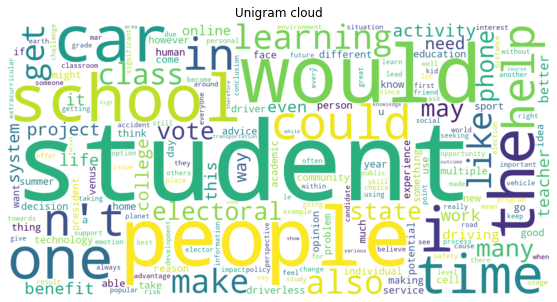

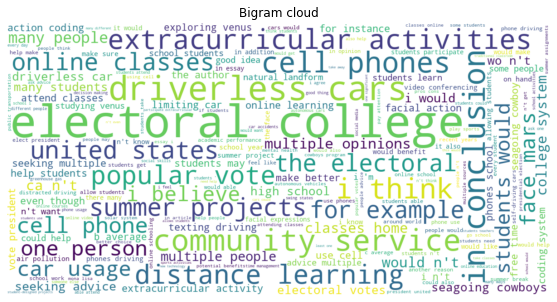

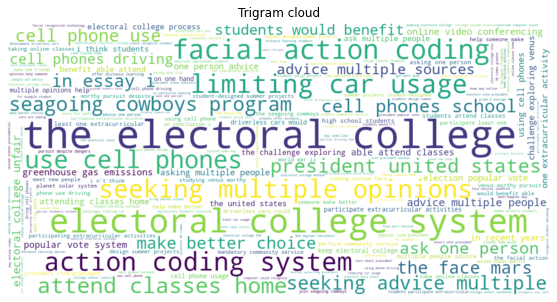

In [137]:
frequencies = unigrams, bigrams_freq, trigrams_freq
for feature in frequencies:
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(feature)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if feature == unigrams:
        plt.title('Unigram cloud')
    elif feature == bigrams_freq:
        plt.title('Bigram cloud')
    else:
        plt.title('Trigram cloud')
    plt.axis('off')
    plt.show()

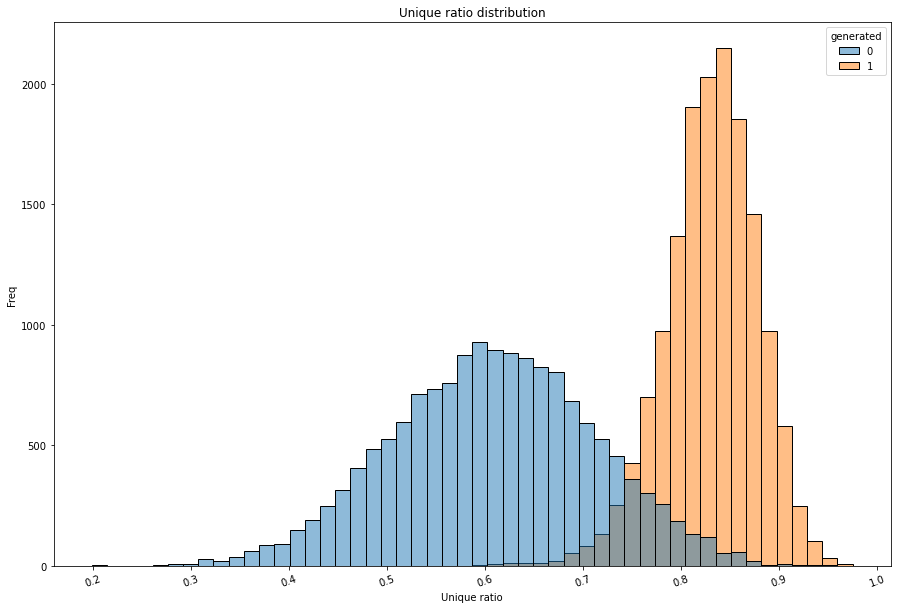

In [138]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='unique_ratio', hue='generated', ax=ax, bins=50)
ax.set_title(f'Unique ratio distribution')
ax.set_xlabel(f'Unique ratio')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

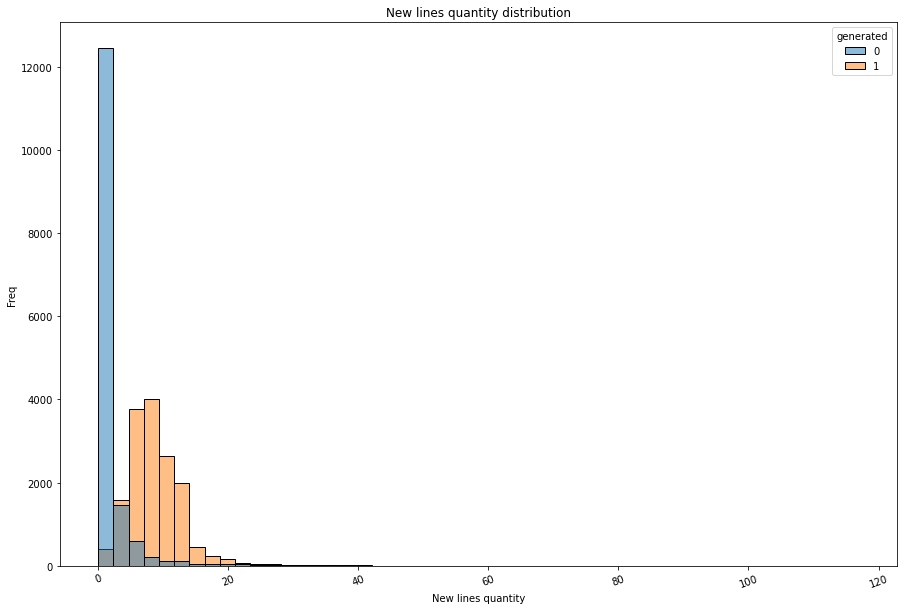

In [139]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='new_lines_quant', hue='generated', ax=ax, bins=50)
ax.set_title(f'New lines quantity distribution')
ax.set_xlabel(f'New lines quantity')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)